# DFT Calculation with ASE Calculator
## Introduction

The `PythonJob` is a built-in task that allows users to run Python functions on a remote computer. For instance, users can use ASE's calculator to run a DFT calculation on a remote computer directly. Users only need to write normal Python code, and the WorkGraph will handle the data transformation to AiiDA data.

The following examples are running with [AiiDA-WorkGraph](https://aiida-workgraph.readthedocs.io/en/latest/).

## First Real-world Workflow: atomization energy of molecule

The atomization energy, $\Delta E$, of a molecule can be expressed as:

$$
\Delta E = n_{\text{atom}} \times E_{\text{atom}} - E_{\text{molecule}}
$$

Where:
- $\Delta E$ is the atomization energy of the molecule.
- $n_{\text{atom}}$ is the number of atoms.
- $E_{\text{atom}}$ is the energy of an isolated atom.
- $E_{\text{molecule}}$ is the energy of the molecule.


### Define a task to calculate the energy of the atoms using EMT potential

In [1]:
from aiida_workgraph import task, WorkGraph

def emt(atoms):
    from ase.calculators.emt import EMT
    atoms.calc = EMT()
    energy = atoms.get_potential_energy()
    return energy


def atomization_energy(mol, energy_molecule, energy_atom):
    energy = energy_atom*len(mol) - energy_molecule
    return energy


### Define a workgraph


In [2]:
wg = WorkGraph("atomization_energy")
pw_atom = wg.add_task("PythonJob", function=emt, name="emt_atom")
pw_mol = wg.add_task("PythonJob", function=emt, name="emt_mol")
wg.add_task("PythonJob", function=atomization_energy, name="atomization_energy",
             energy_atom=pw_atom.outputs["result"],
             energy_molecule=pw_mol.outputs["result"])
wg.to_html()

### Prepare the inputs and submit the workflow

WorkGraph process created, PK: 151193
Energy of a N atom:                  5.100
Energy of an un-relaxed N2 molecule: 0.549
Atomization energy:                  9.651 eV


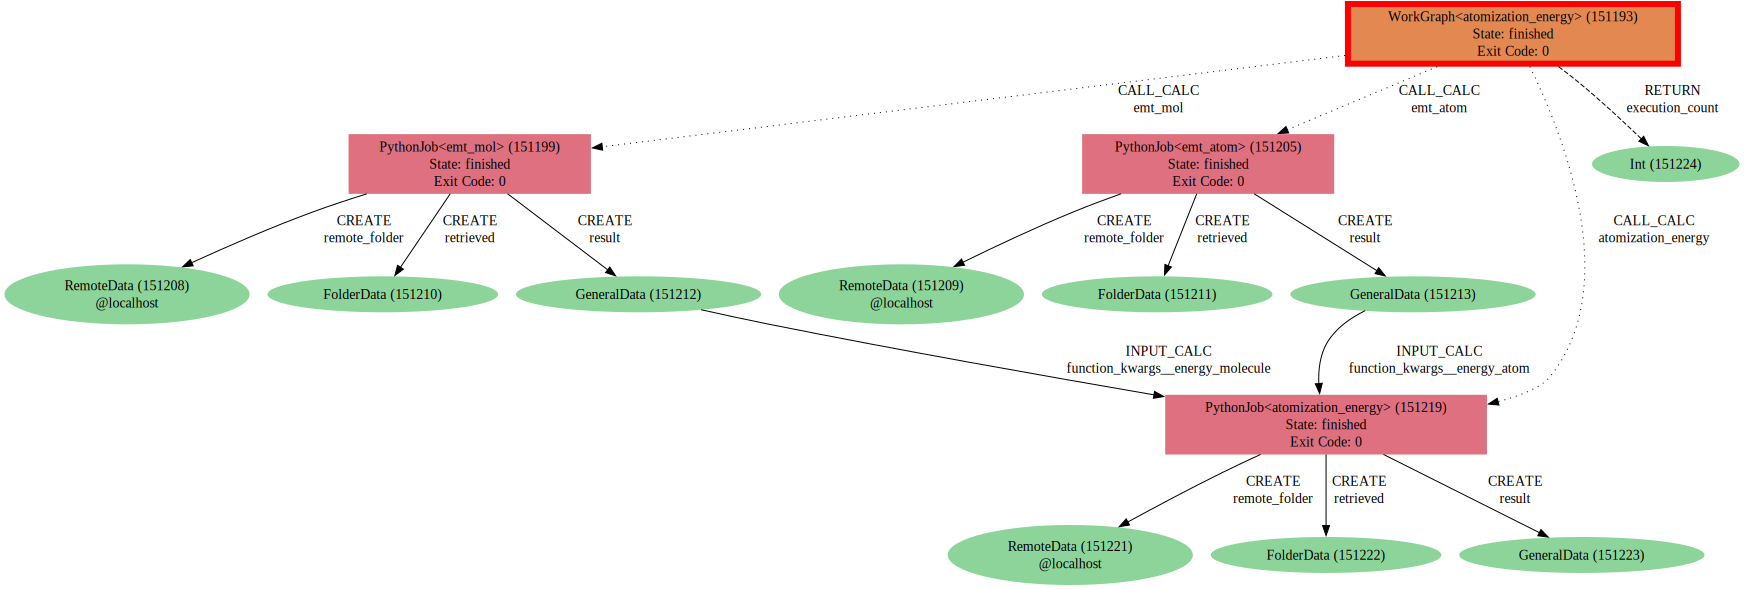

In [9]:
from ase.build import molecule
from ase import Atoms

load_profile()

# create input structure
n_atom = Atoms("N", pbc=True)
n_atom.center(vacuum=5.0)
n2_molecule = molecule("N2", pbc=True)
n2_molecule.center(vacuum=5.0)


#------------------------- Set the inputs -------------------------
wg.tasks["emt_atom"].set({"atoms": n_atom, "computer": "localhost"})
wg.tasks["emt_mol"].set({"atoms": n2_molecule, "computer": "localhost"})
wg.tasks["atomization_energy"].set({"mol": n2_molecule, "computer": "localhost"})
#------------------------- Submit the calculation -------------------
wg.submit(wait=True, timeout=200)
#------------------------- Print the output -------------------------
print('Energy of a N atom:                  {:0.3f}'.format(wg.tasks['emt_atom'].outputs["result"].value.value))
print('Energy of an un-relaxed N2 molecule: {:0.3f}'.format(wg.tasks['emt_mol'].outputs["result"].value.value))
print('Atomization energy:                  {:0.3f} eV'.format(wg.tasks['atomization_energy'].outputs["result"].value.value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)




## Second Real-world Workflow: Equation of state (EOS) WorkGraph



In [3]:
from aiida_workgraph import WorkGraph, task
from ase.build import bulk
from ase import Atoms
from aiida import load_profile

load_profile()

@task(outputs=[{"name": "scaled_atoms", "identifier": "workgraph.namespace"},
               {"name": "volumes"}]
)
def generate_scaled_atoms(atoms: Atoms, scales: list) -> dict:
    """Scale the structure by the given scales."""
    volumes = {}
    scaled_atoms = {}
    for i in range(len(scales)):
        atoms1 = atoms.copy()
        atoms1.set_cell(atoms.cell * scales[i], scale_atoms=True)
        scaled_atoms[f"s_{i}"] = atoms1
        volumes[f"s_{i}"] = atoms1.get_volume()
    return {"scaled_atoms": scaled_atoms, "volumes": volumes}

@task()
def emt(atoms):
    from ase.calculators.emt import EMT
    atoms.calc = EMT()
    energy = atoms.get_potential_energy()
    return {"energy": energy}

# Output result from context to the output socket
@task.graph_builder(outputs=[{"name": "results", "from": "context.results"}])
def calculate_enegies(scaled_atoms):
    """Run the scf calculation for each structure."""
    from aiida_workgraph import WorkGraph
    wg = WorkGraph()
    for key, atoms in scaled_atoms.items():
        emt1 = wg.add_task("PythonJob", function=emt, name=f"emt1_{key}", atoms=atoms)
        emt1.set({"computer": "localhost"})
        # save the output parameters to the context
        emt1.set_context({"result": f"results.{key}"})
    return wg


@task()
def fit_eos(volumes: dict, emt_results: dict) -> dict:
    """Fit the EOS of the data."""
    from ase.eos import EquationOfState
    from ase.units import kJ

    volumes_list = []
    energies = []
    for key, data in emt_results.items():
        energy = data["energy"]
        energies.append(energy)
        volumes_list.append(volumes[key])
    #
    eos = EquationOfState(volumes_list, energies)
    v0, e0, B = eos.fit()
    # convert B to GPa
    B = B / kJ * 1.0e24
    eos = {"energy unit": "eV", "v0": v0, "e0": e0, "B": B}
    return eos

atoms = bulk("Au", cubic=True)

wg = WorkGraph("pythonjob_eos_emt")
scale_atoms_task = wg.add_task("PythonJob",
        function=generate_scaled_atoms,
        name="scale_atoms",
        atoms=atoms,
    )
    # -------- calculate_enegies -----------
calculate_enegies_task = wg.add_task(calculate_enegies,
        name="calculate_enegies",
        scaled_atoms=scale_atoms_task.outputs["scaled_atoms"],
    )
    # -------- fit_eos -----------
wg.add_task("PythonJob",
        function=fit_eos,
        name="fit_eos",
        volumes=scale_atoms_task.outputs["volumes"],
        emt_results=calculate_enegies_task.outputs["results"],
    )
wg.to_html()

In [16]:


wg.submit(
          inputs={"scale_atoms": {"atoms": atoms,
                                  "scales": [0.95, 1.0, 1.05],
                                  "computer": "localhost"},
                    "fit_eos": {"computer": "localhost"}},
          wait=True,
          )

print("The fitted EOS parameters are:")
wg.tasks["fit_eos"].outputs["result"].value.value


WorkGraph process created, PK: 151263
The fitted EOS parameters are:


{'B': 167.61300824791,
 'e0': 0.006458727465855,
 'v0': 67.197735262521,
 'energy unit': 'eV'}

Generate the node graph and check the data provenance.

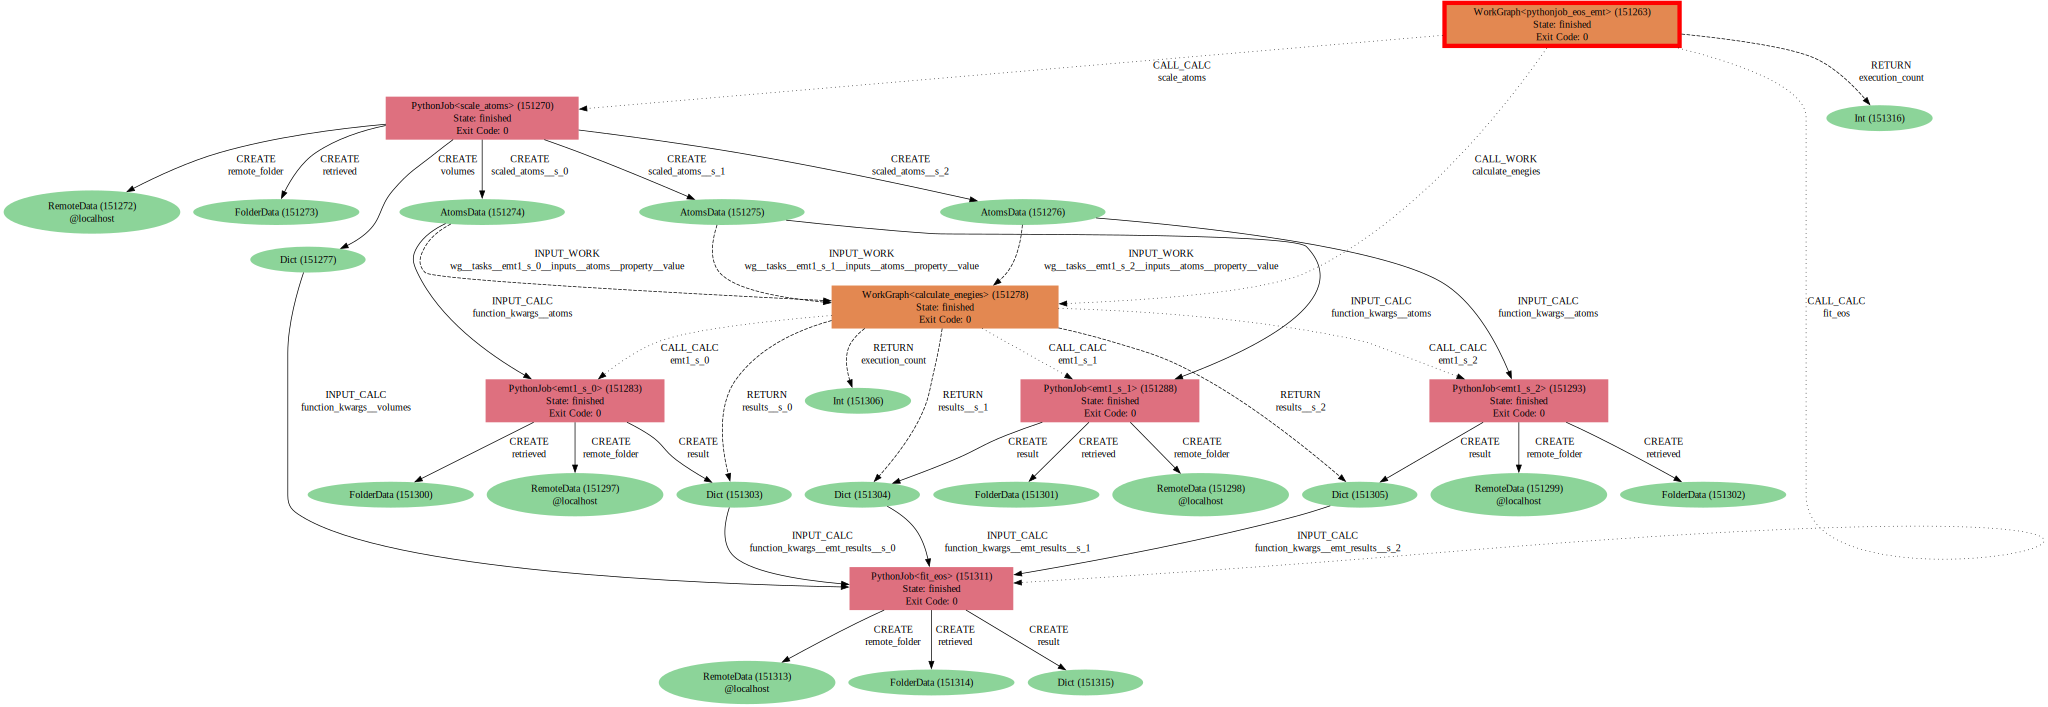

In [17]:
from aiida_workgraph.utils import generate_node_graph

#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)